In [21]:
from dataclasses import dataclass

import numpy as np
import deepxde as dde

from project.gen_data import gen_data
from project.post_processing import Plotter

# Problem parameters:
@dataclass
class PinnConstParam:
    a = 0.4 # Thermal diffusivity
    L = 1 # Length of the bar, Assum x starts at 0
    n = 1 # Frequency of the sinusoidal initial conditions
    t_end = 1 # Assume t_start  = 0
    test_x_dim = 100
    test_t_dim = 100

@dataclass
class PinnTestParam:
    d_num_domain = 2540
    d_num_boundary = 80
    d_num_initial = 160
    nn_hidden_layer_size = 20
    nn_hidden_layer_num = 3

def pde(x, y):
    """
    Expresses the PDE residual of the heat equation.        
    """
    dy_t = dde.grad.jacobian(y, x, i=0, j=1)
    dy_xx = dde.grad.hessian(y, x, i=0, j=0)
    return dy_t - const_params.a*dy_xx

def create_model(const_params: PinnConstParam, test_params: PinnTestParam):
    # Computational geometry:
    geom = dde.geometry.Interval(0, const_params.L)
    timedomain = dde.geometry.TimeDomain(0, const_params.t_end)
    geomtime = dde.geometry.GeometryXTime(geom, timedomain)

    # Initial and boundary conditions:
    bc = dde.DirichletBC(geomtime, lambda x: 0, lambda _, on_boundary: on_boundary)
    ic = dde.IC(
        geomtime, lambda x: np.sin(const_params.n*np.pi*x[:, 0:1]/const_params.L) , lambda _, on_initial: on_initial
        )

    geomtime_data = dde.data.TimePDE(
        geomtime, pde, [bc, ic], 
        num_domain=test_params.d_num_domain,
        num_boundary=test_params.d_num_boundary,
        num_initial=test_params.d_num_initial,
        num_test=2540
    )

    nn_architecture = [2] + [test_params.nn_hidden_layer_size] * test_params.nn_hidden_layer_num + [1]
    net = dde.nn.FNN(
        nn_architecture, 
        "tanh", 
        "Glorot normal")

    model = dde.Model(geomtime_data, net)

    return geomtime_data, model

def train_model(model):
    # Build and train the model:
    model.compile("adam", lr=1e-3)
    model.train(epochs=20000)
    model.compile("L-BFGS")
    losshistory, train_state = model.train()

    return losshistory, train_state

def plot_train_data(geomtime_data):
    X_bc_train = geomtime_data.bc_points()
    print("train_bc_points shape", X_bc_train.shape)

    plotter = Plotter(1, 2)
    plotter.plot_2d(X_bc_train, "train_bc_points")

    # Train points are not used anymore because deepxde train_points(), 
    # always generate random train points, but it is not what we are doing to
    # train the nn, in train_next_batch(). train_next_batch, isnt random!! 
    # X_train_points = geomtime_data.train_points()
    # print("train_points shape", X_train_points.shape)
    # plotter.plot_2d(X_train_points, "train_domain_points")

    X_train_next_batch, _, _ = geomtime_data.train_next_batch()
    print("train_next_batch shape", X_train_next_batch.shape)
    plotter.plot_2d(X_train_next_batch, "train_next_batch")

def predict_and_output_report(X_test, y_true, model, losshistory = None, train_state = None):
    # Analytical test solution
    plotter = Plotter(1, 2)

    plotter.plot_2d_y(X_test, y_true, "Analytical solution")

    # Physics Informed Neural Network test solution``
    y_pred = model.predict(X_test)
    plotter.plot_2d_y(X_test, y_pred, "PINN prediction")

    # Train loss, and Test data from PDE test data
    if losshistory and train_state:
        dde.saveplot(losshistory, train_state, issave=False, isplot=True)
    print("IGNORE ^^^ PDE test data SOLUTION PLOT!!! ^^^")

    f = model.predict(X_test, operator=pde)
    print("Mean residual:", np.mean(np.absolute(f)))
    print("L2 relative error:", dde.metrics.l2_relative_error(y_true, y_pred))
    # np.savetxt("test.dat", np.hstack((X_test, y_true, y_pred)))

# Generate constants throughout this app!!
const_params = PinnConstParam()
  
X_test, y_true = gen_data(
    "heat_1d_boundary_sin_exact",
    {
        "x_range": (0, const_params.L),
        "t_range": (0, const_params.t_end),
        "x_dim": const_params.test_x_dim,
        "t_dim": const_params.test_t_dim, 
        "a_coeff": const_params.a,
        "frequency": const_params.n,
    })


# Test 1: Default parameters from DeepXde

train_bc_points shape (240, 2)
train_next_batch shape (3020, 2)


/home/radian/anaconda3/envs/tf-gpu/lib/python3.9/site-packages/skopt/sampler/sobol.py:246: UserWarning: The balance properties of Sobol' points require n to be a power of 2. 0 points have been previously generated, then: n=0+2542=2542. 
  warnings.warn("The balance properties of Sobol' points require "
/home/radian/anaconda3/envs/tf-gpu/lib/python3.9/site-packages/skopt/sampler/sobol.py:246: UserWarning: The balance properties of Sobol' points require n to be a power of 2. 0 points have been previously generated, then: n=0+82=82. 
  warnings.warn("The balance properties of Sobol' points require "
/home/radian/anaconda3/envs/tf-gpu/lib/python3.9/site-packages/skopt/sampler/sobol.py:246: UserWarning: The balance properties of Sobol' points require n to be a power of 2. 0 points have been previously generated, then: n=0+162=162. 
  warnings.warn("The balance properties of Sobol' points require "


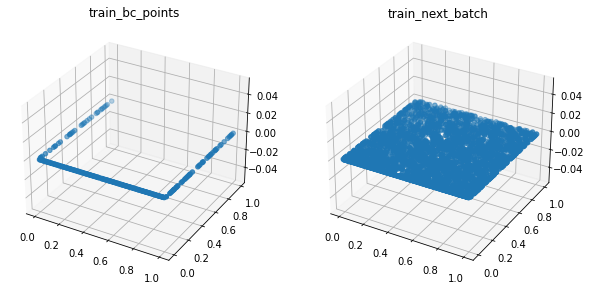

In [22]:
# Create model and plot training data
geomtime_data, model = create_model(const_params, PinnTestParam())
plot_train_data(geomtime_data)

Compiling model...
Building feed-forward neural network...
'build' took 0.141411 s



/home/radian/anaconda3/envs/tf-gpu/lib/python3.9/site-packages/tensorflow/python/keras/legacy_tf_layers/core.py:171: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  warnings.warn('`tf.layers.dense` is deprecated and '
/home/radian/anaconda3/envs/tf-gpu/lib/python3.9/site-packages/tensorflow/python/keras/engine/base_layer_v1.py:1719: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '
2021-12-08 14:54:37.032620: I tensorflow/compiler/jit/xla_gpu_device.cc:99] Not creating XLA devices, tf_xla_enable_xla_devices not set


'compile' took 0.338856 s

Initializing variables...
Training model...

0         [1.34e-03, 3.79e-02, 3.50e-01]    [1.17e-03, 3.79e-02, 3.50e-01]    []  
1000      [1.13e-03, 1.94e-04, 1.96e-04]    [6.94e-04, 1.94e-04, 1.96e-04]    []  
2000      [2.39e-04, 1.49e-05, 2.34e-05]    [1.68e-04, 1.49e-05, 2.34e-05]    []  
3000      [1.20e-04, 8.97e-06, 1.25e-05]    [8.60e-05, 8.97e-06, 1.25e-05]    []  
4000      [7.51e-05, 5.26e-06, 7.59e-06]    [5.27e-05, 5.26e-06, 7.59e-06]    []  
5000      [1.74e-04, 6.05e-06, 4.25e-05]    [1.25e-04, 6.05e-06, 4.25e-05]    []  
6000      [4.37e-05, 5.06e-06, 1.82e-05]    [2.87e-05, 5.06e-06, 1.82e-05]    []  
7000      [2.93e-05, 3.30e-06, 5.68e-06]    [1.87e-05, 3.30e-06, 5.68e-06]    []  
8000      [2.20e-05, 1.38e-06, 1.90e-06]    [1.43e-05, 1.38e-06, 1.90e-06]    []  
9000      [4.23e-05, 1.94e-06, 6.40e-06]    [2.95e-05, 1.94e-06, 6.40e-06]    []  
10000     [5.21e-05, 1.64e-05, 6.55e-05]    [4.01e-05, 1.64e-05, 6.55e-05]    []  
11000     [1.23

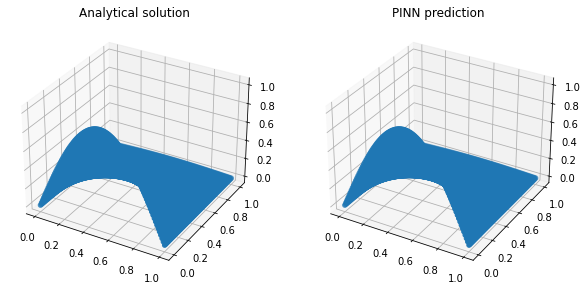

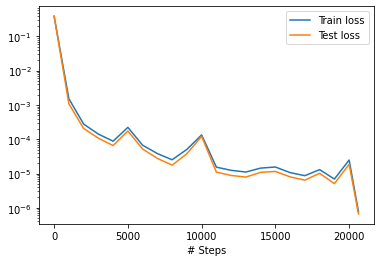

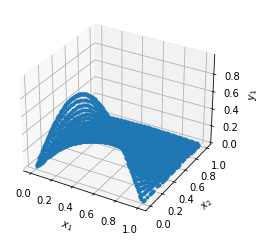

IGNORE ^^^ PDE test data SOLUTION PLOT!!! ^^^
Mean residual: 0.0006153124
L2 relative error: 0.0006466863146935275


In [12]:
# Train model and output results
losshistory, train_state = train_model(model)
predict_and_output_report(X_test, y_true, model, losshistory, train_state)


# Test 2: Reduce hidden layers and size to break solution

train_bc_points shape (240, 2)
train_next_batch shape (3020, 2)


/home/radian/anaconda3/envs/tf-gpu/lib/python3.9/site-packages/skopt/sampler/sobol.py:246: UserWarning: The balance properties of Sobol' points require n to be a power of 2. 0 points have been previously generated, then: n=0+2542=2542. 
  warnings.warn("The balance properties of Sobol' points require "
/home/radian/anaconda3/envs/tf-gpu/lib/python3.9/site-packages/skopt/sampler/sobol.py:246: UserWarning: The balance properties of Sobol' points require n to be a power of 2. 0 points have been previously generated, then: n=0+82=82. 
  warnings.warn("The balance properties of Sobol' points require "
/home/radian/anaconda3/envs/tf-gpu/lib/python3.9/site-packages/skopt/sampler/sobol.py:246: UserWarning: The balance properties of Sobol' points require n to be a power of 2. 0 points have been previously generated, then: n=0+162=162. 
  warnings.warn("The balance properties of Sobol' points require "


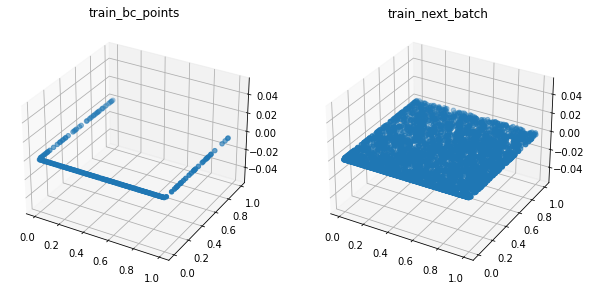

In [13]:
test_params = PinnTestParam()
test_params.nn_hidden_layer_num = 1
test_params.nn_hidden_layer_size = 5

geomtime_data, model = create_model(const_params, test_params)

Compiling model...
Building feed-forward neural network...
'build' took 0.017144 s

'compile' took 0.174245 s

Initializing variables...


/home/radian/anaconda3/envs/tf-gpu/lib/python3.9/site-packages/tensorflow/python/keras/legacy_tf_layers/core.py:171: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  warnings.warn('`tf.layers.dense` is deprecated and '
/home/radian/anaconda3/envs/tf-gpu/lib/python3.9/site-packages/tensorflow/python/keras/engine/base_layer_v1.py:1719: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '
2021-12-08 14:55:46.868375: I tensorflow/compiler/jit/xla_gpu_device.cc:99] Not creating XLA devices, tf_xla_enable_xla_devices not set


Training model...

Step      Train loss                        Test loss                         Test metric
0         [2.36e-01, 3.73e-01, 1.95e-01]    [2.28e-01, 3.73e-01, 1.95e-01]    []  
1000      [2.01e-02, 4.93e-02, 1.13e-01]    [1.86e-02, 4.93e-02, 1.13e-01]    []  
2000      [1.50e-02, 3.59e-02, 6.25e-02]    [1.27e-02, 3.59e-02, 6.25e-02]    []  
3000      [4.75e-03, 3.60e-02, 4.72e-02]    [4.18e-03, 3.60e-02, 4.72e-02]    []  
4000      [5.03e-03, 2.65e-02, 3.80e-02]    [4.48e-03, 2.65e-02, 3.80e-02]    []  
5000      [4.79e-03, 1.64e-02, 2.46e-02]    [3.83e-03, 1.64e-02, 2.46e-02]    []  
6000      [7.20e-03, 9.64e-03, 1.66e-02]    [5.35e-03, 9.64e-03, 1.66e-02]    []  
7000      [8.48e-03, 6.49e-03, 1.26e-02]    [6.27e-03, 6.49e-03, 1.26e-02]    []  
8000      [9.33e-03, 5.00e-03, 1.03e-02]    [7.07e-03, 5.00e-03, 1.03e-02]    []  
9000      [9.58e-03, 4.39e-03, 9.08e-03]    [7.42e-03, 4.39e-03, 9.08e-03]    []  
10000     [9.66e-03, 4.08e-03, 8.32e-03]    [7.64e-03, 4.08e-

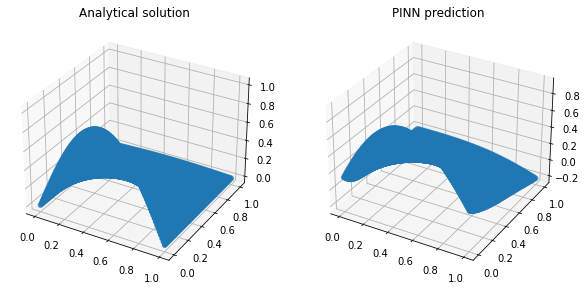

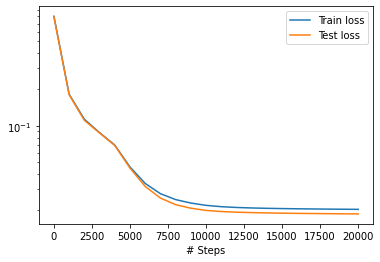

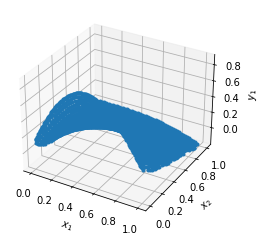

IGNORE ^^^ PDE test data SOLUTION PLOT!!! ^^^
Mean residual: 0.07227356
L2 relative error: 0.19020109884287337


In [14]:
# Train model and output results
losshistory, train_state = train_model(model)
predict_and_output_report(X_test, y_true, model, losshistory, train_state)

# Test 3: Reduce boundary points to break solution

train_bc_points shape (6, 2)
train_next_batch shape (2552, 2)


/home/radian/anaconda3/envs/tf-gpu/lib/python3.9/site-packages/skopt/sampler/sobol.py:246: UserWarning: The balance properties of Sobol' points require n to be a power of 2. 0 points have been previously generated, then: n=0+5=5. 
  warnings.warn("The balance properties of Sobol' points require "


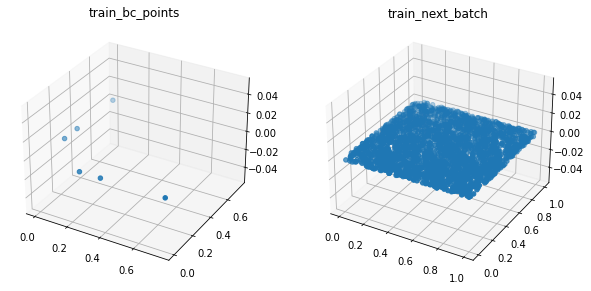

In [23]:
test_params = PinnTestParam()
test_params.d_num_boundary = 3
test_params.d_num_initial = 3

geomtime_data, model = create_model(const_params, test_params)
plot_train_data(geomtime_data)

Compiling model...
Building feed-forward neural network...
'build' took 0.038655 s



/home/radian/anaconda3/envs/tf-gpu/lib/python3.9/site-packages/tensorflow/python/keras/legacy_tf_layers/core.py:171: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  warnings.warn('`tf.layers.dense` is deprecated and '
/home/radian/anaconda3/envs/tf-gpu/lib/python3.9/site-packages/tensorflow/python/keras/engine/base_layer_v1.py:1719: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '
2021-12-08 15:01:18.252964: I tensorflow/compiler/jit/xla_gpu_device.cc:99] Not creating XLA devices, tf_xla_enable_xla_devices not set


'compile' took 0.491716 s

Initializing variables...
Training model...

Step      Train loss                        Test loss                         Test metric
0         [4.85e-01, 1.35e-01, 3.42e-01]    [4.83e-01, 1.35e-01, 3.42e-01]    []  
1000      [1.64e-03, 1.03e-03, 5.29e-03]    [1.23e-03, 1.03e-03, 5.29e-03]    []  
2000      [3.85e-04, 3.22e-05, 1.14e-03]    [2.83e-04, 3.22e-05, 1.14e-03]    []  
3000      [1.59e-04, 1.64e-07, 7.45e-05]    [1.14e-04, 1.64e-07, 7.45e-05]    []  
4000      [7.91e-05, 1.08e-06, 1.12e-05]    [6.01e-05, 1.08e-06, 1.12e-05]    []  
5000      [3.99e-05, 1.47e-06, 3.29e-06]    [2.92e-05, 1.47e-06, 3.29e-06]    []  
6000      [2.31e-05, 1.86e-06, 1.41e-06]    [1.66e-05, 1.86e-06, 1.41e-06]    []  
7000      [1.46e-05, 1.96e-06, 7.62e-07]    [1.05e-05, 1.96e-06, 7.62e-07]    []  
8000      [9.90e-06, 1.94e-06, 5.02e-07]    [7.18e-06, 1.94e-06, 5.02e-07]    []  
9000      [7.29e-06, 1.89e-06, 3.85e-07]    [5.49e-06, 1.89e-06, 3.85e-07]    []  
10000   

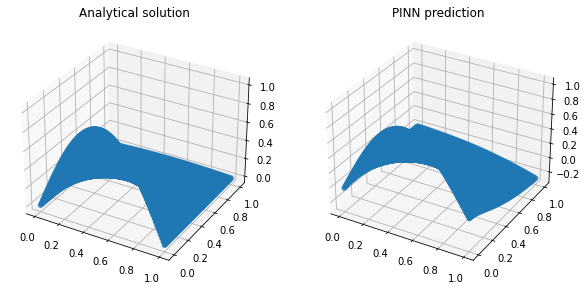

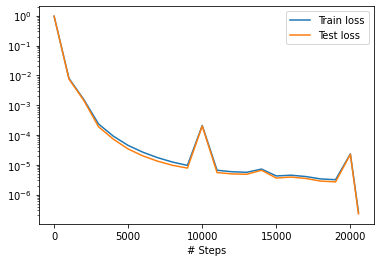

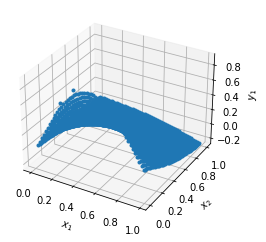

IGNORE ^^^ PDE test data SOLUTION PLOT!!! ^^^
Mean residual: 0.0004205553
L2 relative error: 0.2770035514872247


In [24]:
# Train model and output results
losshistory, train_state = train_model(model)
predict_and_output_report(X_test, y_true, model, losshistory, train_state)

# Test 4: Reduce domain to break solution

train_bc_points shape (240, 2)
train_next_batch shape (530, 2)


/home/radian/anaconda3/envs/tf-gpu/lib/python3.9/site-packages/skopt/sampler/sobol.py:246: UserWarning: The balance properties of Sobol' points require n to be a power of 2. 0 points have been previously generated, then: n=0+52=52. 
  warnings.warn("The balance properties of Sobol' points require "
/home/radian/anaconda3/envs/tf-gpu/lib/python3.9/site-packages/skopt/sampler/sobol.py:246: UserWarning: The balance properties of Sobol' points require n to be a power of 2. 0 points have been previously generated, then: n=0+82=82. 
  warnings.warn("The balance properties of Sobol' points require "
/home/radian/anaconda3/envs/tf-gpu/lib/python3.9/site-packages/skopt/sampler/sobol.py:246: UserWarning: The balance properties of Sobol' points require n to be a power of 2. 0 points have been previously generated, then: n=0+162=162. 
  warnings.warn("The balance properties of Sobol' points require "


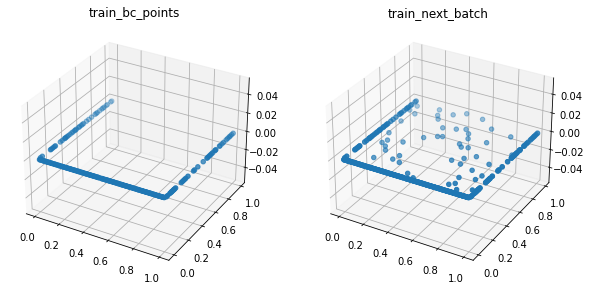

In [17]:
test_params = PinnTestParam()
test_params.d_num_domain = 50

geomtime_data, model = create_model(const_params, test_params)
plot_train_data(geomtime_data)

/home/radian/anaconda3/envs/tf-gpu/lib/python3.9/site-packages/tensorflow/python/keras/legacy_tf_layers/core.py:171: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  warnings.warn('`tf.layers.dense` is deprecated and '
/home/radian/anaconda3/envs/tf-gpu/lib/python3.9/site-packages/tensorflow/python/keras/engine/base_layer_v1.py:1719: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Compiling model...
Building feed-forward neural network...
'build' took 0.035561 s



2021-12-08 14:57:01.405130: I tensorflow/compiler/jit/xla_gpu_device.cc:99] Not creating XLA devices, tf_xla_enable_xla_devices not set


'compile' took 0.291370 s

Initializing variables...
Training model...

Step      Train loss                        Test loss                         Test metric
0         [9.79e-03, 1.05e-01, 1.00e+00]    [6.46e-03, 1.05e-01, 1.00e+00]    []  
1000      [1.89e-03, 6.52e-04, 4.24e-04]    [7.19e-03, 6.52e-04, 4.24e-04]    []  
2000      [4.42e-04, 9.28e-05, 4.83e-05]    [3.44e-03, 9.28e-05, 4.83e-05]    []  
3000      [2.09e-04, 2.49e-05, 2.94e-05]    [2.07e-03, 2.49e-05, 2.94e-05]    []  
4000      [2.14e-04, 1.10e-05, 2.01e-05]    [1.52e-03, 1.10e-05, 2.01e-05]    []  
5000      [9.91e-05, 7.75e-06, 1.36e-05]    [1.08e-03, 7.75e-06, 1.36e-05]    []  
6000      [8.00e-05, 6.32e-06, 9.89e-06]    [8.85e-04, 6.32e-06, 9.89e-06]    []  
7000      [6.67e-05, 5.15e-06, 7.23e-06]    [7.55e-04, 5.15e-06, 7.23e-06]    []  
8000      [5.68e-05, 4.60e-06, 5.60e-06]    [6.62e-04, 4.60e-06, 5.60e-06]    []  
9000      [5.82e-05, 4.11e-06, 4.41e-06]    [6.02e-04, 4.11e-06, 4.41e-06]    []  
10000   

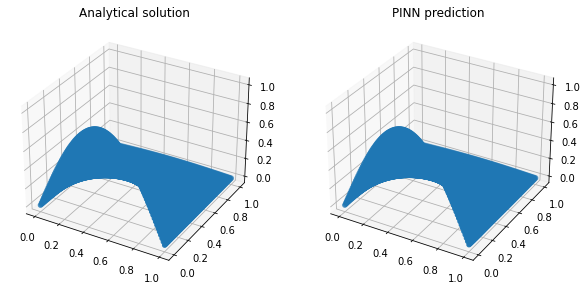

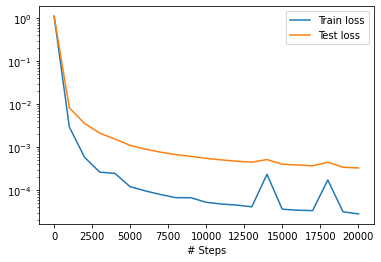

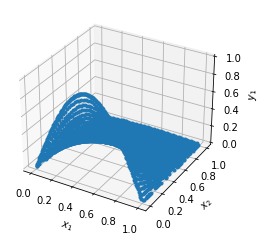

IGNORE ^^^ PDE test data SOLUTION PLOT!!! ^^^
Mean residual: 0.011785117
L2 relative error: 0.005293482670770511


In [18]:
# Train model and output results
losshistory, train_state = train_model(model)
predict_and_output_report(X_test, y_true, model, losshistory, train_state)

# Test 5: Reduce train data (domain and bc) to break solution

train_bc_points shape (20, 2)
train_next_batch shape (90, 2)


/home/radian/anaconda3/envs/tf-gpu/lib/python3.9/site-packages/skopt/sampler/sobol.py:246: UserWarning: The balance properties of Sobol' points require n to be a power of 2. 0 points have been previously generated, then: n=0+52=52. 
  warnings.warn("The balance properties of Sobol' points require "
/home/radian/anaconda3/envs/tf-gpu/lib/python3.9/site-packages/skopt/sampler/sobol.py:246: UserWarning: The balance properties of Sobol' points require n to be a power of 2. 0 points have been previously generated, then: n=0+12=12. 
  warnings.warn("The balance properties of Sobol' points require "


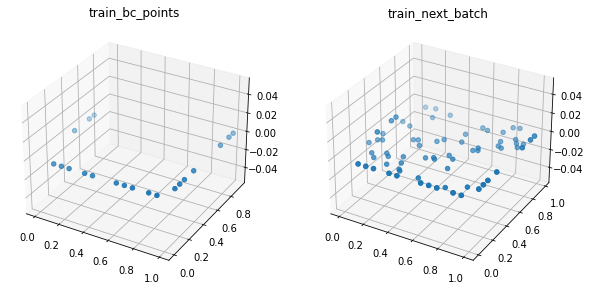

In [19]:
test_params = PinnTestParam()
test_params.d_num_domain = 50
test_params.d_num_boundary = 10
test_params.d_num_initial = 10

geomtime_data, model = create_model(const_params, test_params)
plot_train_data(geomtime_data)

Compiling model...
Building feed-forward neural network...


/home/radian/anaconda3/envs/tf-gpu/lib/python3.9/site-packages/tensorflow/python/keras/legacy_tf_layers/core.py:171: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  warnings.warn('`tf.layers.dense` is deprecated and '
/home/radian/anaconda3/envs/tf-gpu/lib/python3.9/site-packages/tensorflow/python/keras/engine/base_layer_v1.py:1719: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


'build' took 0.033520 s



2021-12-08 14:57:25.932561: I tensorflow/compiler/jit/xla_gpu_device.cc:99] Not creating XLA devices, tf_xla_enable_xla_devices not set


'compile' took 0.306161 s

Initializing variables...
Training model...

Step      Train loss                        Test loss                         Test metric
0         [8.22e-02, 2.72e-02, 6.91e-01]    [8.77e-02, 2.72e-02, 6.91e-01]    []  
1000      [2.21e-03, 8.36e-04, 2.92e-03]    [2.22e-03, 8.36e-04, 2.92e-03]    []  
2000      [3.13e-04, 1.18e-05, 4.56e-05]    [6.94e-04, 1.18e-05, 4.56e-05]    []  
3000      [5.62e-05, 1.18e-06, 5.84e-06]    [2.58e-04, 1.18e-06, 5.84e-06]    []  
4000      [3.37e-05, 4.49e-07, 2.01e-06]    [1.53e-04, 4.49e-07, 2.01e-06]    []  
5000      [2.45e-05, 2.27e-07, 7.59e-07]    [1.16e-04, 2.27e-07, 7.59e-07]    []  
6000      [1.82e-05, 1.42e-07, 3.64e-07]    [9.65e-05, 1.42e-07, 3.64e-07]    []  
7000      [1.50e-05, 2.66e-07, 2.01e-07]    [8.31e-05, 2.66e-07, 2.01e-07]    []  
8000      [1.28e-05, 1.98e-07, 2.38e-07]    [7.47e-05, 1.98e-07, 2.38e-07]    []  
9000      [9.86e-06, 1.19e-07, 7.00e-08]    [6.98e-05, 1.19e-07, 7.00e-08]    []  
10000   

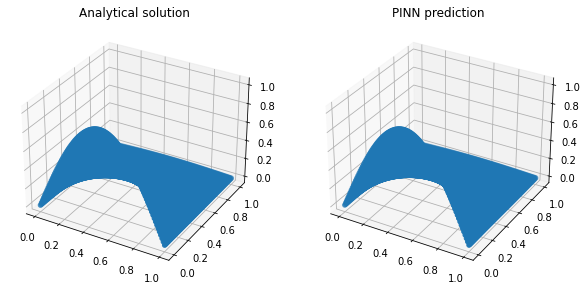

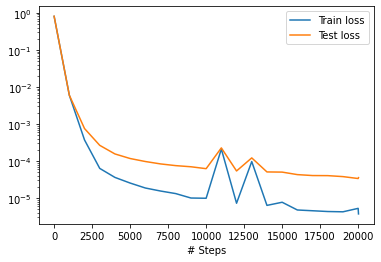

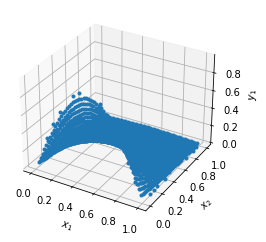

IGNORE ^^^ PDE test data SOLUTION PLOT!!! ^^^
Mean residual: 0.0032352207
L2 relative error: 0.003662818841577474


In [20]:
# Train model and output results
losshistory, train_state = train_model(model)
predict_and_output_report(X_test, y_true, model, losshistory, train_state)